# Image Viewer

So we've finally done it folks. In the raw image viewer code, you will see some extra lines to add a red circle to known locations of malignant tumors based on the annotations csv file.  When you run the code and start playing with the slice viewer, you will find right above the image slider there is a label that displays the slice numbers that correspond to the center of the malignant tumors.  Code explanation:
* Python gets the origin and the spacing of the individual patient's CT scan.  These are usually unique for each patient, so it has to be calculated each time (maybe we'll add a cache feature later)
* Python finds the patient, selected in the dropdown, in the dataframe/annotations.csv file (if they exist in the file)
* If the patient is in the annotations files, python subsets the annotations dataframe for just the patient we selected in the dropdown
* Python drops the seriesuid (patient ID) column for simplicity later on; I figured we wouldn't need that column in the dataframe anymore
* Python then transforms the x, y, z, and diameter coordinates from millimeters to voxel (3D pixel) coordinates.  This is accomplished by subtracting the respective axis origin found with GetOrigin() and dividing by the respective axis spacing found with GetSpacing()
* Python then applies a rounding function to every element of the dataframe (the patient ID column would have thrown an error if it hadn't been dropped). Since pixels and slice numbers of the raw file array are in whole numbers, our coordinates have to be whole numbers too.
* Once the coordinates are calculated for a patient with cancer, when you (the user) select a patient and slice within the widgets, matplotlib adds a circle/"patch" to the image circling the tumor based on the transformed coordinates.  One note is that I made the circle a little larger than the specified diameter so we can see what the tumor really looks like; in some instances, however, the tumor is much larger than the circle.

I made it work, now let's make it work better.  Make sure my rounding/math is logical and commit changes to fix my mistakes and make the code run more smoothly.  Good hunting!

# DICOM Image Viewer

In [1]:
%%cmd
pip install pydicom
pip install SimpleITK

Microsoft Windows [Version 6.1.7601]
Copyright (c) 2009 Microsoft Corporation.  All rights reserved.

C:\Users\576473\Documents\GitHub\DSB-2017\jupyter_notebooks>pip install pydicom

C:\Users\576473\Documents\GitHub\DSB-2017\jupyter_notebooks>pip install SimpleITK

C:\Users\576473\Documents\GitHub\DSB-2017\jupyter_notebooks>

In [2]:
#Load necessary packages
import os
import dicom
import SimpleITK as sitk
import numpy as np
import pandas as pd
from ipywidgets import widgets, interact, interactive, IntSlider
from IPython.display import display,clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

In [3]:
#Hard coded paths
dicom_path = 'E:/DSB 2017/stage1/stage1' #Hard code the location of the stage1 data 
stage1_labels_path = 'E:/DSB 2017/stage1_labels.csv'
raw_path = 'E:/LUNA16' #Hard code the location of the data
annotations_path = "E:/LUNA16/annotations.csv"

In [4]:
# Load list of all patients

dicom_patients = sorted(os.listdir(dicom_path))
dicom_patients_indexlist = [str(patientindex) + ': ' for patientindex in range(0, len(dicom_patients))]#I made this list because I wanted to prepend the list of patients with their numerical id
stage1_labels = pd.read_csv(stage1_labels_path, header = 0) #hard code the location of your stage1_labels.csv file
stage1_cancer = []
for s in stage1_labels.cancer:
    if s == 1: 
        stage1_cancer.append(" ^ ")
    elif s == 0:
        stage1_cancer.append("")
#above: this for loop creates a list of either carets or nothing that corresponds to whether a patient in the stage1_labels csv file has cancer or not
combined_stage1_list = [x+y+z for x,y,z in zip(dicom_patients_indexlist, stage1_cancer, dicom_patients)] #this creates a list of patient ids and carets (or nothing) if they have cancer, and then the actual patient number

#Instantiate Controls
dicom_patient_list = widgets.Select(description = 'Patients',options = combined_stage1_list)  # populate the drop down with the sorted list of patients, 
    #with their appropriate index number and a ^ at the end if the patient has cancer according to the stage1_labels.csv file
dicom_img_slider = IntSlider(description = "Image Number", min = 0, value = 0) # create image slider and set min = 0; we won't know the max until a patient is selected
#play_scan = widgets.Play(min = 0,
                         #step = 1,
                         #description = "Play CT scan",
                         #disabled = False)
#The above play_scan button was an attempt to create a play button to "play" the CT scans, but we have to figure out how to slow down the playing of images so the images have enough time to render on the screen; right now the player moves too quickly
#Also, for asthetics, it would be great if the pictures would fade in and out instead of flashing like they do

In [5]:
os.path.join(dicom_path,dicom_patients[dicom_patient_list.options.index(dicom_patient_list.value)])

'E:/DSB 2017/stage1/stage1\\0015ceb851d7251b8f399e39779d1e7d'

In [6]:
# Function to load a patient's data
def load_dicom_patient(args = ''):
    dicom_patient_path = os.path.join(dicom_path,dicom_patients[dicom_patient_list.options.index(dicom_patient_list.value)])  #store the path to the selected patient.
    #above, within the .join(), this goofy setup ensures the patient value is grabbed, then the index of that patient within the overall dicom patient list, then that index is fed into the dicom_patients list to get the real patient number.  If someone can find a more simple method for this, please commit.
    global dicom_slices
    dicom_slices = [dicom.read_file(dicom_patient_path + '/' + s) for s in os.listdir(dicom_patient_path)] #read in the individual slices
    dicom_slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) #sort slices based on vertical position
    dicom_img_slider.max = len(dicom_slices) - 1 #set the max of the image slider
    #play_scan.max = len(dicom_slices) - 1 #set the max of the play_scan widget
    plot_dicom_img()
    
def plot_dicom_img(args = ''):
    dicom_img = dicom_slices[dicom_img_slider.value].pixel_array #extract the image data from the selected slice
    clear_output(wait = True)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(dicom_img,cmap=plt.cm.gray)
    ax.axes.axis('off')

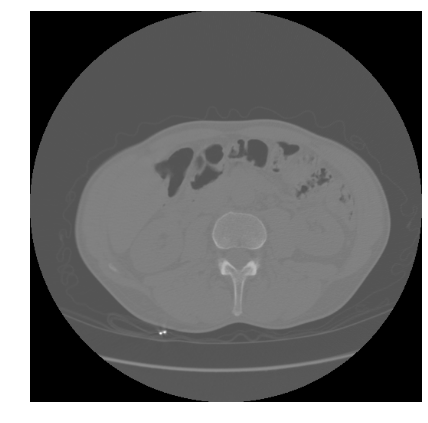

In [7]:
dicom_patient_list.observe(load_dicom_patient,'value')
#play_scan.observe(plot_dicom_img,'value')
dicom_img_slider.observe(plot_dicom_img,'value')

#widgets.jslink((play_scan, 'value'), (dicom_img_slider, 'value')) #this widget is to link the play button and the slider so the numbers correspond

display(dicom_patient_list)
#display(play_scan)
display(dicom_img_slider)

load_dicom_patient()

# RAW Image Viewer

In [8]:
all_files = os.listdir(raw_path)
raw_patients = [i for i in all_files if '.mhd' in i]
raw_patients = sorted(raw_patients)
raw_patients = [i[:-4] for i in raw_patients] #I did this to remove the ".mhd" from the end of each of the patients numbers, just an aesthetic
raw_patients_indexlist = [str(patientindex) + ': ' for patientindex in range(0, len(raw_patients))]

cancer_annotations = pd.read_csv(annotations_path, header = 0)#Hard code the location of the annotations file
cancerannotations_list = sorted(list(set(cancer_annotations['seriesuid'].tolist())))
LUNA16_cancer = []
for i in raw_patients:
    try:
        cancerannotations_list.index(i)
        LUNA16_cancer.append(" * ")
    except: 
        LUNA16_cancer.append("")

combined_raw_list = [x+y+z for x,y,z in zip(raw_patients_indexlist, LUNA16_cancer, raw_patients)]
        
raw_patient_list = widgets.Select(description = 'Patients',options = combined_raw_list)  # populate the drop down with the sorted list of patients
raw_img_slider = IntSlider(description = "Image Number", min = 0) # create image slider and set min = 0; we won't know the max until a patient is selected
#cancer_labels = widgets.Label() # this is a label that displays the slice number of malignant tumor centers

In [9]:
def get_cancer_coordinates():
    raw_spacing = raw_slices.GetSpacing() #grabs the raw file spacing
    raw_origin = raw_slices.GetOrigin() # grabs the raw file origin 
    if raw_patients[raw_patient_list.options.index(raw_patient_list.value)] in cancer_annotations.seriesuid.values:
        patient_annotations = cancer_annotations[cancer_annotations.seriesuid == raw_patients[raw_patient_list.options.index(raw_patient_list.value)]] #this line subsets the annotations file for just the patient selected in the dropdown
        patient_annotations_transform = patient_annotations.drop('seriesuid', axis = 1) #dropping the patient ID column
        patient_annotations_transform.loc[:,'coordX'] = patient_annotations_transform.loc[:,'coordX'] - raw_origin[0]# the next ~7 lines transforms our coordinates from mm/world coordinates to voxel coordinates 
        patient_annotations_transform.loc[:,'coordY'] = patient_annotations_transform.loc[:,'coordY'] - raw_origin[1]
        patient_annotations_transform.loc[:,'coordZ'] = patient_annotations_transform.loc[:,'coordZ'] - raw_origin[2]
        patient_annotations_transform.loc[:,'coordX'] = patient_annotations_transform.loc[:,'coordX'] / raw_spacing[0]
        patient_annotations_transform.loc[:,'coordY'] = patient_annotations_transform.loc[:,'coordY'] / raw_spacing[1]
        patient_annotations_transform.loc[:,'coordZ'] = patient_annotations_transform.loc[:,'coordZ'] / raw_spacing[2]
        patient_annotations_transform.loc[:,'diameter_mm'] = patient_annotations_transform.loc[:,'diameter_mm'] / raw_spacing[0]
        patient_annotations_transform = patient_annotations_transform.applymap(round) #the rounding function applied to all elements
        return patient_annotations_transform
    else: return pd.DataFrame()
    
def load_raw_patient(args = ''):
    raw_patient_path = os.path.join(raw_path,raw_patients[raw_patient_list.options.index(raw_patient_list.value)]+'.mhd')  #store the path to the selected patient
    global raw_slices, raw_slices_array
    raw_slices = sitk.ReadImage(raw_patient_path)
    raw_slices_array = sitk.GetArrayFromImage(raw_slices)
    raw_img_slider.max = len(raw_slices_array) - 1 #set the max of the image slider
    #patient_annotations_transform = get_cancer_coordinates()
    #if not patient_annotations_transform.empty:
        #raw_img_slider.value = sorted([int(i) for i in patient_annotations_transform.coordZ.values])[0]
    #else: raw_img_slider.value = 0
    raw_img_slider.value = 0
    plot_raw_img()
    
def plot_raw_img(args = ''):
    clear_output(wait = True)
    raw_img = raw_slices_array[raw_img_slider.value] #extract the image data from the selected slice

    patient_annotations_transform = get_cancer_coordinates()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(raw_img,cmap=plt.cm.gray)
    ax.axes.axis('off')
    
    if not patient_annotations_transform.empty:
        #cancer_labels.value = "Slice number(s) of malignant tumors: "+', '.join([str(i) for i in sorted([int(i) for i in patient_annotations_transform.coordZ.values])]) #this line sets the value of the tumor slice label
        print "Slice number(s) of malignant tumors: "+', '.join([str(i) for i in sorted([int(i) for i in patient_annotations_transform.coordZ.values])]) #this line sets the value of the tumor slice label
        if raw_img_slider.value in patient_annotations_transform.coordZ.values:
            x = patient_annotations_transform.loc[patient_annotations_transform['coordZ']==raw_img_slider.value].coordX.values #the three lines below create ordered lists of x, y, and radius coordinates of the tumor if the slice number corresponds to a known z coordinate (z coordinates = slice numbers)
            y = patient_annotations_transform.loc[patient_annotations_transform['coordZ']==raw_img_slider.value].coordY.values
            r = np.round(patient_annotations_transform.loc[patient_annotations_transform['coordZ']==raw_img_slider.value].diameter_mm.values/2, decimals = 0)
            for xx,yy,rr in zip(x,y,r):
                circ = Circle((xx,yy), radius = (rr+4), fill = False, edgecolor = 'red') #I put rr+4 because I wanted to make the circle a little bigger than the tumor so we could see the tumor fairly clearly
                ax.add_patch(circ)
                #the above for loop creates a circle, from the correctly ordered x, y, and radius coordinates, that outlines the malignant tumor in red
    else: 
        print "This patient does not have malignant tumor cells"

Slice number(s) of malignant tumors: 180


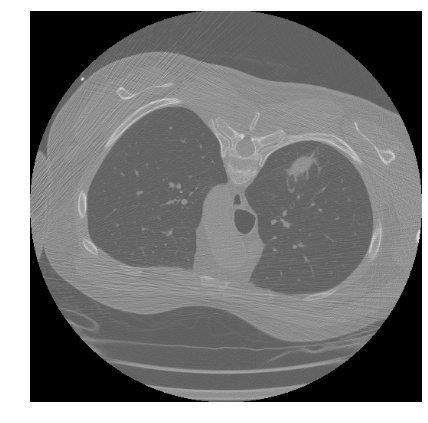

In [10]:
raw_patient_list.observe(load_raw_patient,'value')
raw_img_slider.observe(plot_raw_img,'value')

display(raw_patient_list)
#display(cancer_labels)
display(raw_img_slider)

load_raw_patient()

In [ ]:
#801945620899034889998809817499